In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/data_curation/cs_mdfps_schema_experimental_data.csv')

In [10]:
df.columns

Index(['molregno', 'conf_id', 'vp_log10_pa', 'mdfp', 'molblock',
       'md_experiment_uuid', 'confgen_uuid', 'ROMol', 'smiles'],
      dtype='object')

In [4]:
molblocks = df['molblock'].tolist()
from rdkit import Chem
mols = [Chem.MolFromMolBlock(molblock) for molblock in molblocks]
print(len(mols))

3050


In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.SimDivFilters import rdSimDivPickers

picker = rdSimDivPickers.MaxMinPicker()

def pick_most_diverse_molecules(smiles_list, num_picks=10):
    # Convert SMILES to RDKit molecule objects
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    
    # Compute ECFP4 fingerprints for each molecule
    fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in mols]
    
    # Use the MaxMinPicker to select the most diverse molecules
    picker = rdSimDivPickers.MaxMinPicker()
    picks = picker.LazyBitVectorPick(fps, len(fps), num_picks)
    
    # Return the selected SMILES strings
    diverse_smiles = [smiles_list[i] for i in picks]
    return diverse_smiles

# Select 10 diverse molecules from the dataset
diverse_mols = pick_most_diverse_molecules(df['smiles'].tolist(), num_picks=10)

'CCCCCCCCCCCCCCCO'

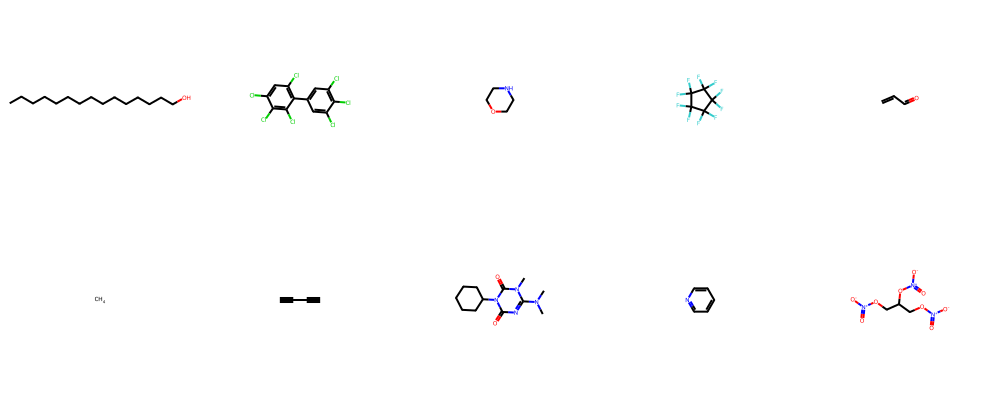

In [7]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in diverse_mols], molsPerRow=5)

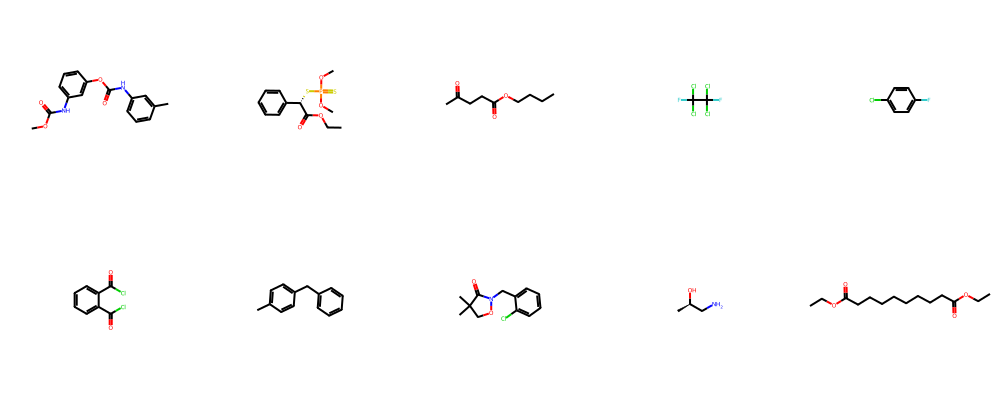

In [9]:
#additionally, just pick 10 random
import random
random_smiles = random.sample(df['smiles'].tolist(), 10)
Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in random_smiles], molsPerRow=5)

In [13]:
#get the confids for these molecules from the df
confids_diverse = df[df['smiles'].isin(diverse_mols)]['conf_id'].tolist()
confids_random = df[df['smiles'].isin(random_smiles)]['conf_id'].tolist()
print(confids_diverse, confids_random)

[2397, 1906, 2004, 15865, 1335, 2606, 1498, 3516, 16764, 16848] [3178, 16216, 1408, 1308, 3397, 2955, 3393, 3827, 15900, 16259]


In [14]:
confids_to_test = confids_diverse + confids_random
print(confids_to_test)

[2397, 1906, 2004, 15865, 1335, 2606, 1498, 3516, 16764, 16848, 3178, 16216, 1408, 1308, 3397, 2955, 3393, 3827, 15900, 16259]


In [2]:
import pandas as pd
df = pd.read_csv('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/data_curation/cs_mdfps_schema_experimental_data.csv')
confids_to_test = [2397, 1906, 2004, 15865, 1335, 2606, 1498, 3516, 16764, 16848, 3178, 16216, 1408, 1308, 3397, 2955, 3393, 3827, 15900, 16259]



#mdfptools
from Parameteriser import LiquidParameteriser
from Simulator import LiquidSimulator
from Composer import LiquidComposer

#rdkit
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem.rdmolfiles import MolFromMolFile

#database
import psycopg2
import uuid
import json

#other
import mdtraj as md
import pickle
import sys
import os

def sim(confid):
    print(confid)
    Md_Experiment_uuid = 'equil_test_10random_10diverse'
    topo_filename = f"topologies/{Md_Experiment_uuid}/{confid}.pickle"
    #check if pickle with topo_file exists
    if os.path.exists(topo_filename):
        print('Topology already exists, loading...')
        rdk_pmd = pickle.load(open(topo_filename, "rb"))
        print('Topology loaded, simulating...')

    else:
        print('Confid: ', confid)
        mol = Chem.MolFromMolBlock(df[df['conf_id'] == confid]['molblock'].values[0])
        smiles = Chem.MolToSmiles(mol)
        print('Molobject created, parameterising...')
        rdk_pmd = LiquidParameteriser.via_rdkit(smiles = smiles)
        pickle.dump(rdk_pmd, open(topo_filename, "wb"))
        print('Topology saved, simulating...')


    traj_path = f"trajectories/{Md_Experiment_uuid}"
    if not os.path.exists(f'{traj_path}/{confid}.h5'):
        print('Simulating...')
        LiquidSimulator.via_openmm(rdk_pmd, file_name = confid, file_path = traj_path,
                                    platform = "CUDA", num_steps = 5000 * 10)
        print('Simulation done')
    else:
        print('Simulation already exists')

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
for confid in confids_to_test:
    sim(confid)

2397
Topology already exists, loading...
Topology loaded, simulating...
Simulation already exists
1906
Topology already exists, loading...


Topology loaded, simulating...
Simulation already exists
2004
Topology already exists, loading...
Topology loaded, simulating...
Simulation already exists
15865
Topology already exists, loading...
Topology loaded, simulating...
Simulation already exists
1335
Topology already exists, loading...
Topology loaded, simulating...
Simulation already exists
2606
Topology already exists, loading...
Topology loaded, simulating...
Simulation already exists
1498
Topology already exists, loading...
Topology loaded, simulating...
Simulating...


OpenMMException: NonbondedForce: The cutoff distance cannot be greater than half the periodic box size.  For more information, see https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#boxsize

In [5]:
df[df['conf_id'] == 1498]

,molregno,conf_id,vp_log10_pa,mdfp,molblock,md_experiment_uuid,confgen_uuid,ROMol,smiles
2036,353,1498,7.793102,"{'mdfp': '[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.14...",[H]C([H])([H])[H]\n RDKit 3D\n\n ...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef269460>,C


issue because too small. repack? but how to handle this in general? either way, the params for these will be different (either shorter cut-off or bigger big). I think repacking with a bigger box is fair, but then we have to somehow register this different. Think about this for a bit!

In [3]:
confids_to_test_left = [3516, 16764, 16848, 3178, 16216, 1408, 1308, 3397, 2955, 3393, 3827, 15900, 16259]
for confid in confids_to_test_left:
    sim(confid)

3516
Topology already exists, loading...
Topology loaded, simulating...
Simulation already exists
16764
Topology already exists, loading...
Topology loaded, simulating...
Simulation already exists
16848
Topology already exists, loading...
Topology loaded, simulating...
Simulation already exists
3178
Topology already exists, loading...
Topology loaded, simulating...
Simulation already exists
16216
Topology already exists, loading...
Topology loaded, simulating...
Simulation already exists
1408
Topology already exists, loading...
Topology loaded, simulating...
Simulation already exists
1308
Topology already exists, loading...
Topology loaded, simulating...
Simulation already exists
3397
Topology already exists, loading...
Topology loaded, simulating...
Simulation already exists
2955
Topology already exists, loading...
Topology loaded, simulating...
Simulation already exists
3393
Topology already exists, loading...
Topology loaded, simulating...
Simulation already exists
3827
Topology alr

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


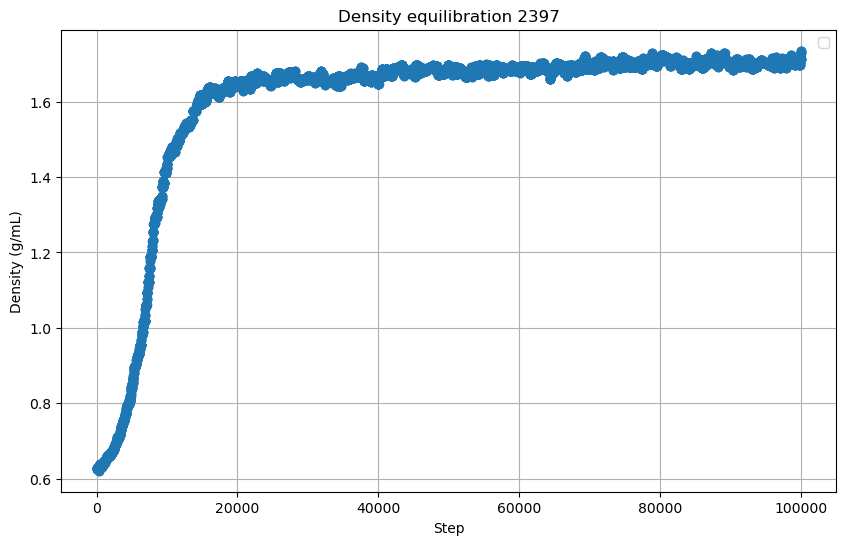

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


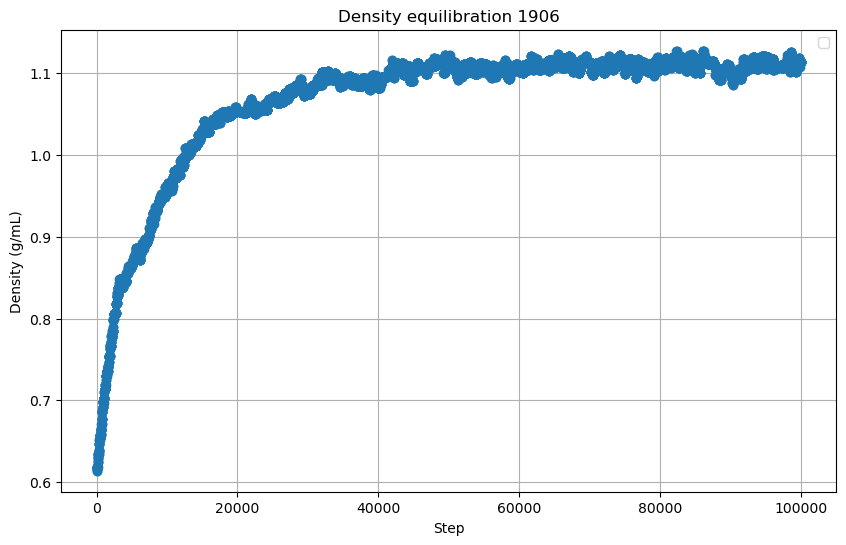

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


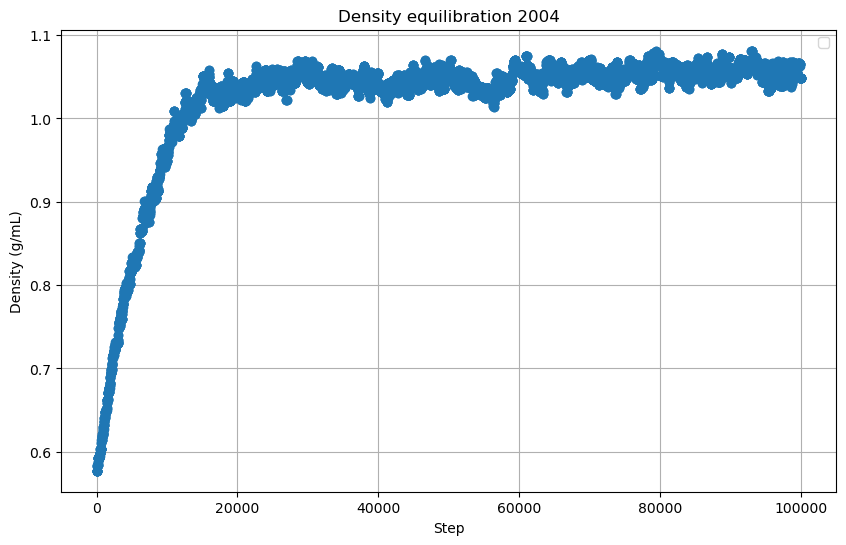

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


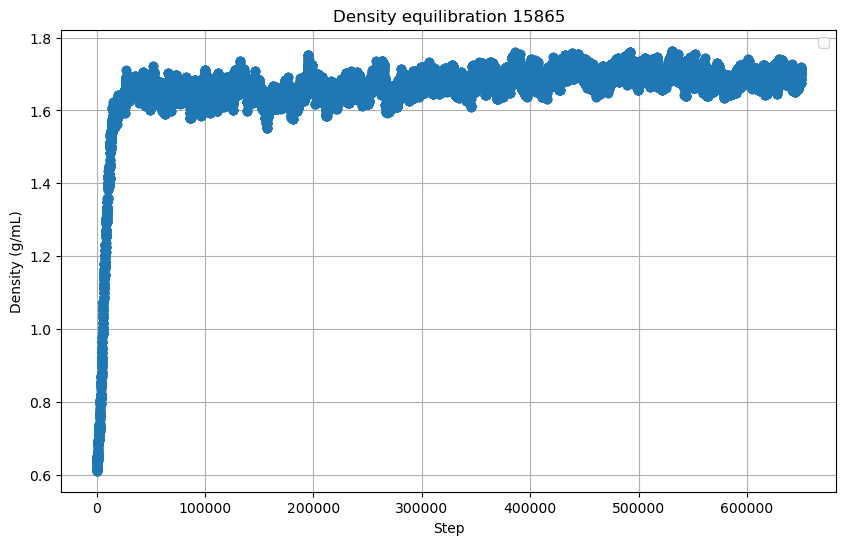

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


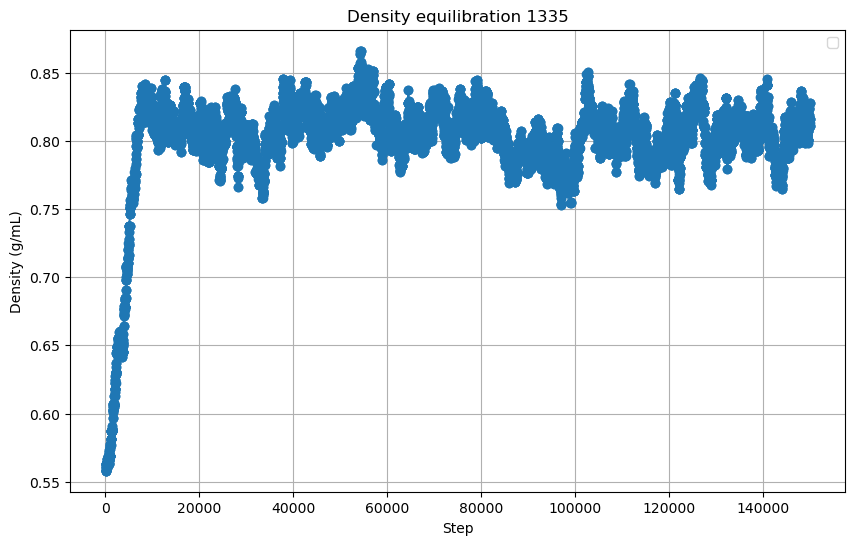

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


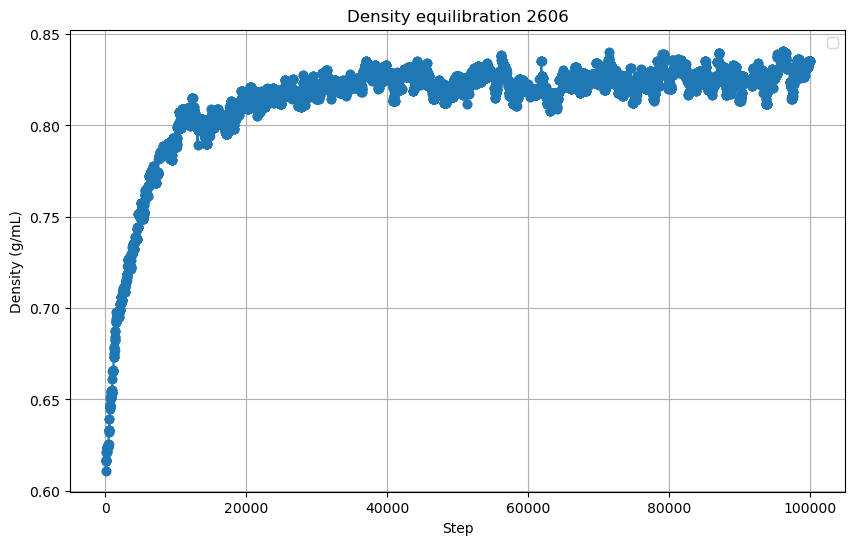

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No data for 1498


<Figure size 1000x600 with 0 Axes>

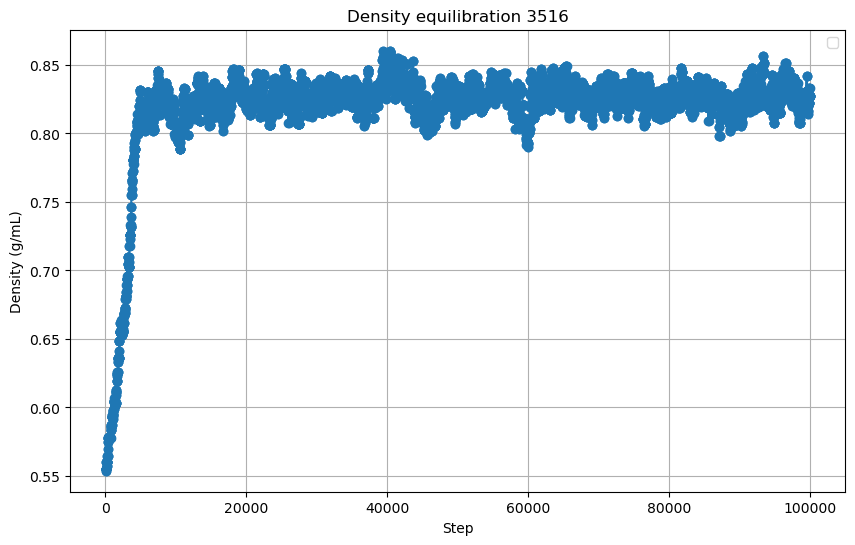

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


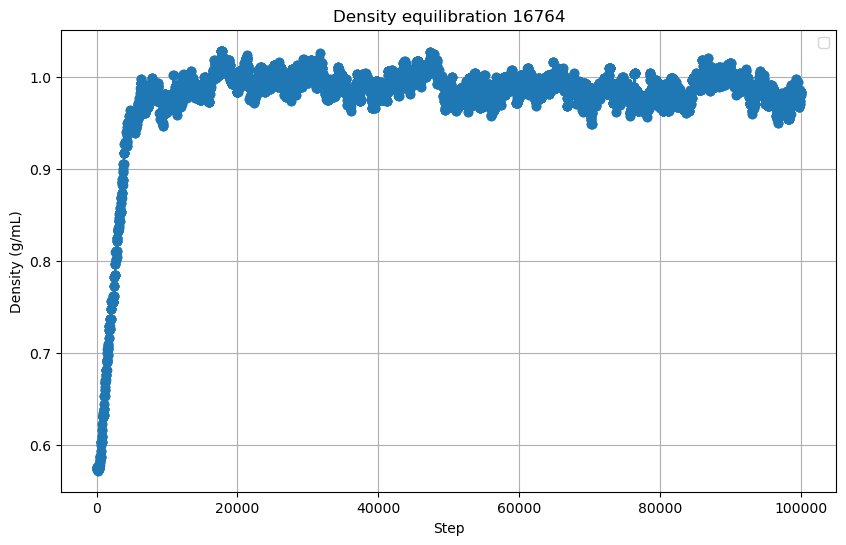

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


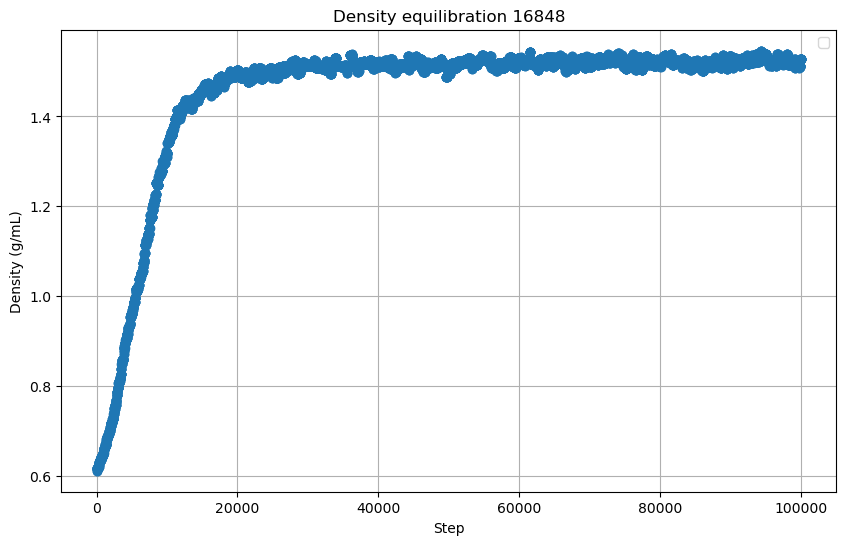

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


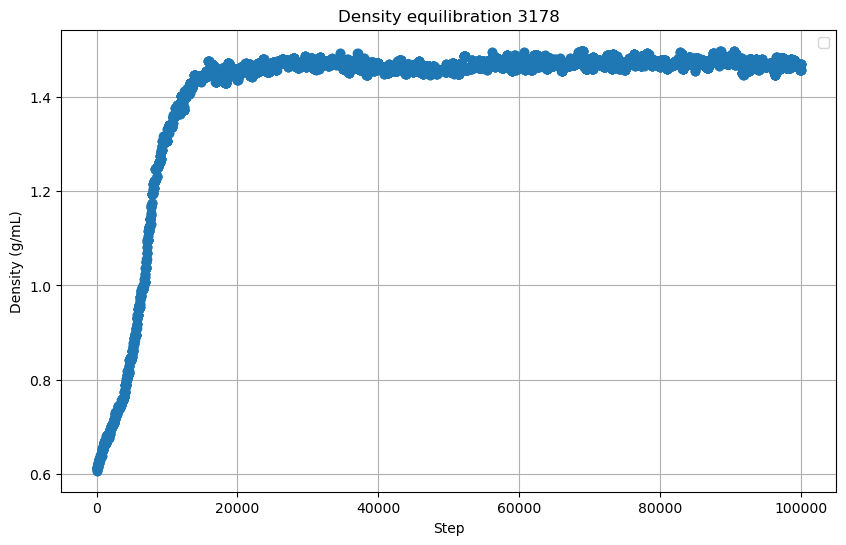

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


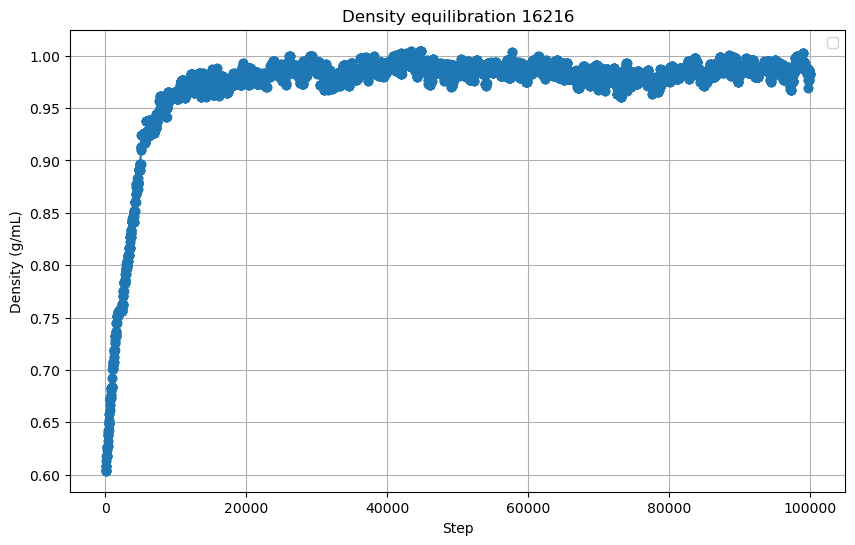

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


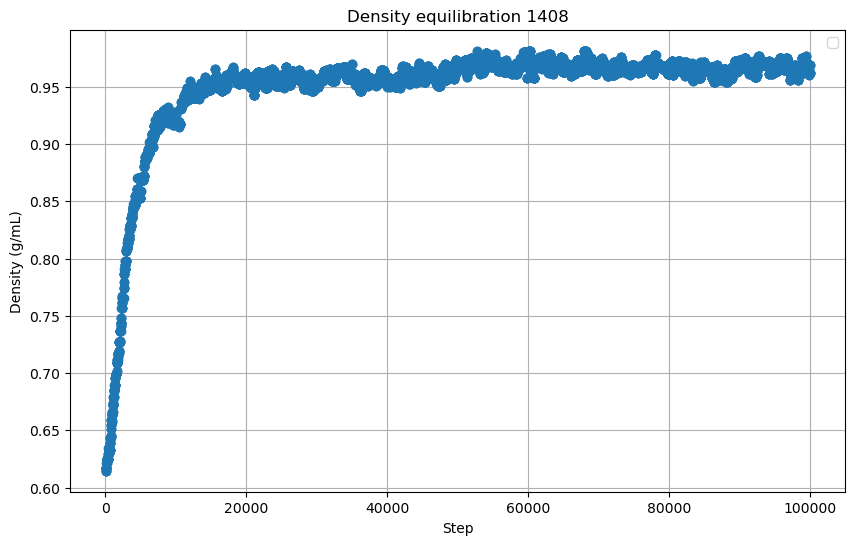

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


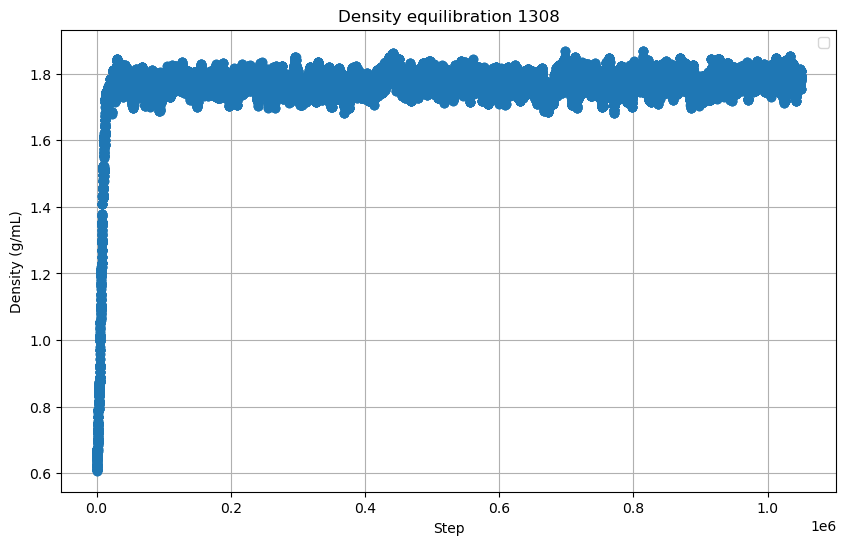

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


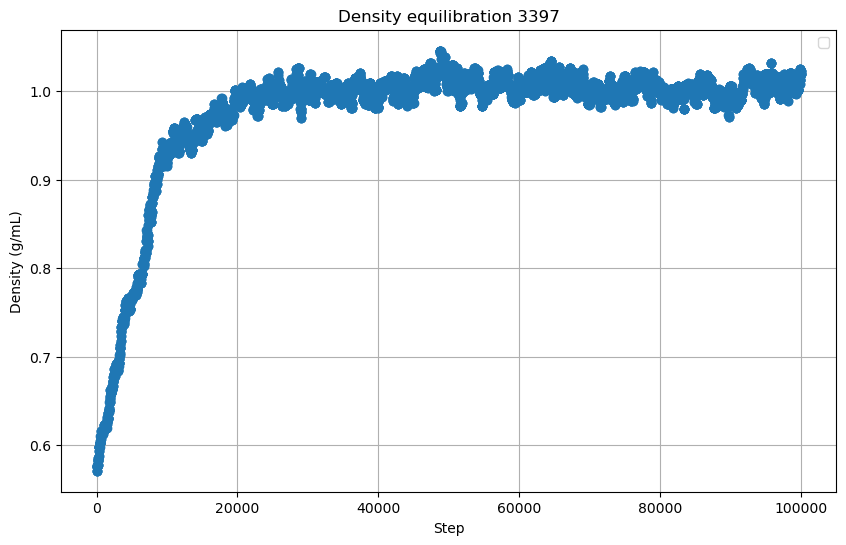

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


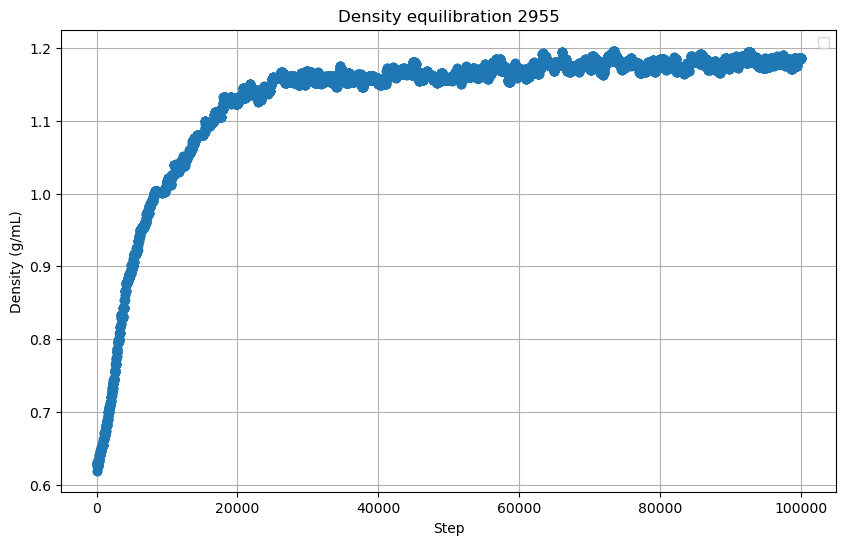

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


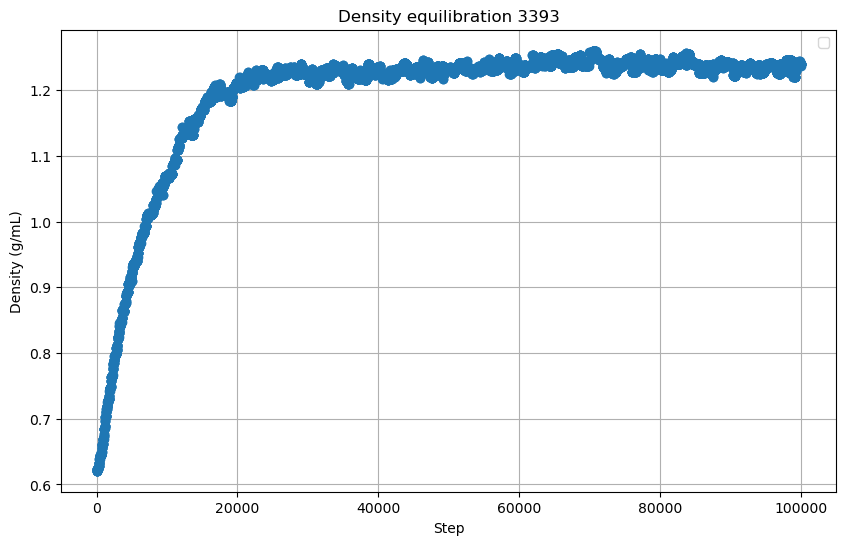

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


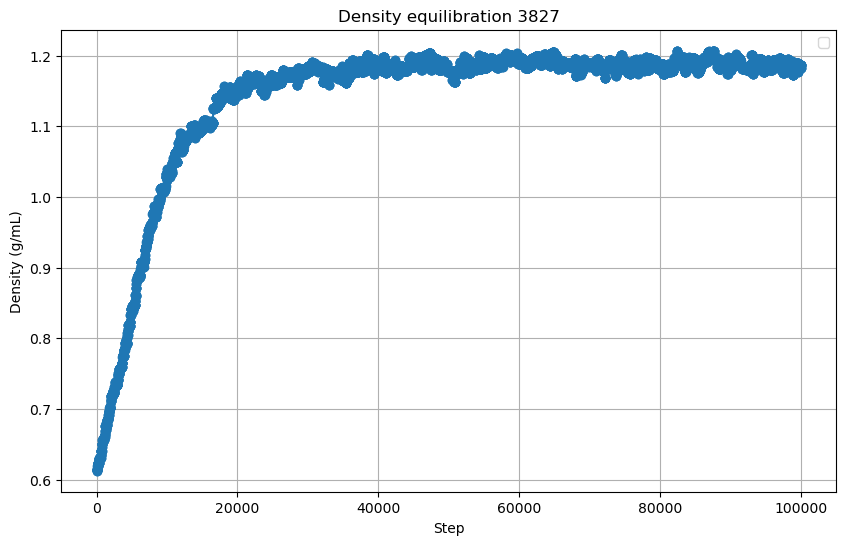

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


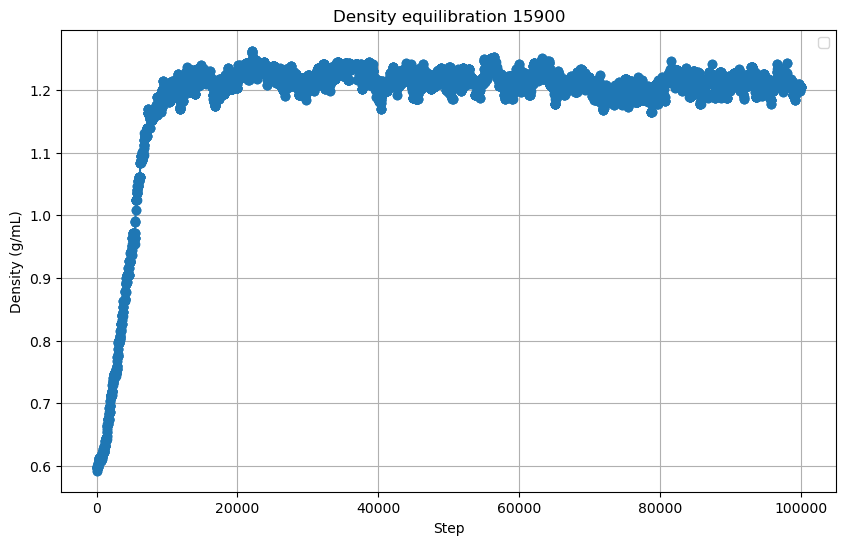

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


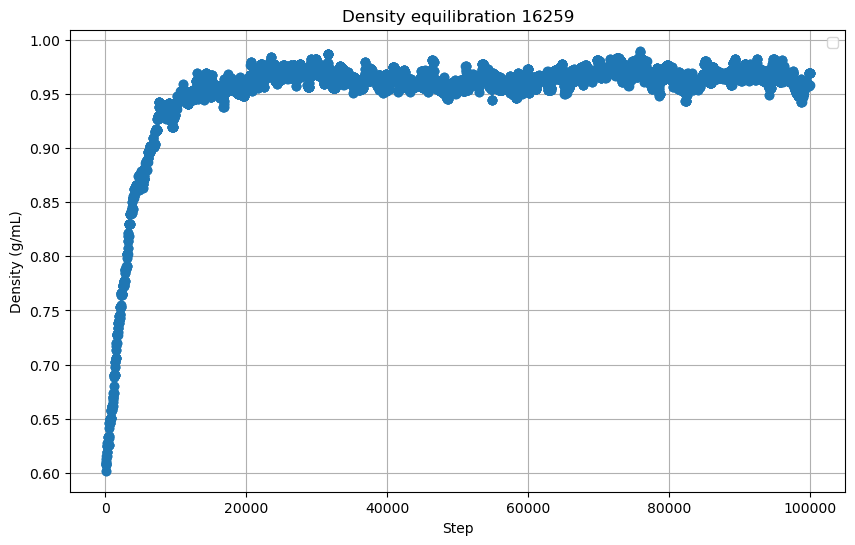

In [6]:
#plot density in equilibration
import pandas as pd
import matplotlib.pyplot as plt
import glob
def plot_density_equil(confid):
    plt.figure(figsize=(10, 6))
    filenames = glob.glob(f'trajectories/equil_test_10random_10diverse/equilibration_{confid}*.dat')
    #read in the dfs, and combine them vertically, if more then one
    dfs = [pd.read_csv(file) for file in filenames]
    df = pd.concat(dfs)
    df= df.sort_values(by='#"Step"', ascending=False)
    df = df.drop_duplicates(subset=['#"Step"'], keep='first')
    plt.plot(df['#"Step"'], df['Density (g/mL)'], marker='o', linestyle='-')
    plt.xlabel('Step')
    plt.ylabel('Density (g/mL)')
    plt.title(f'Density equilibration {confid}')
    plt.grid(True)
    plt.legend()
    plt.show()
    return df
# df_2397 = plot_density_equil(2397)
confids_to_test = [2397, 1906, 2004, 15865, 1335, 2606, 1498, 3516, 16764, 16848, 3178, 16216, 1408, 1308, 3397, 2955, 3393, 3827, 15900, 16259]
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import io
from PIL import Image
def draw_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    drawer = rdMolDraw2D.MolDraw2DCairo(500,180,200,180)
    drawer.drawOptions().useBWAtomPalette()
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    bio = io.BytesIO(drawer.GetDrawingText())
    Image.open(bio)


for confid in confids_to_test:
    try:
        plot_density_equil(confid)
       
    except ValueError:
        print(f'No data for {confid}')
        continue

No data for 1498


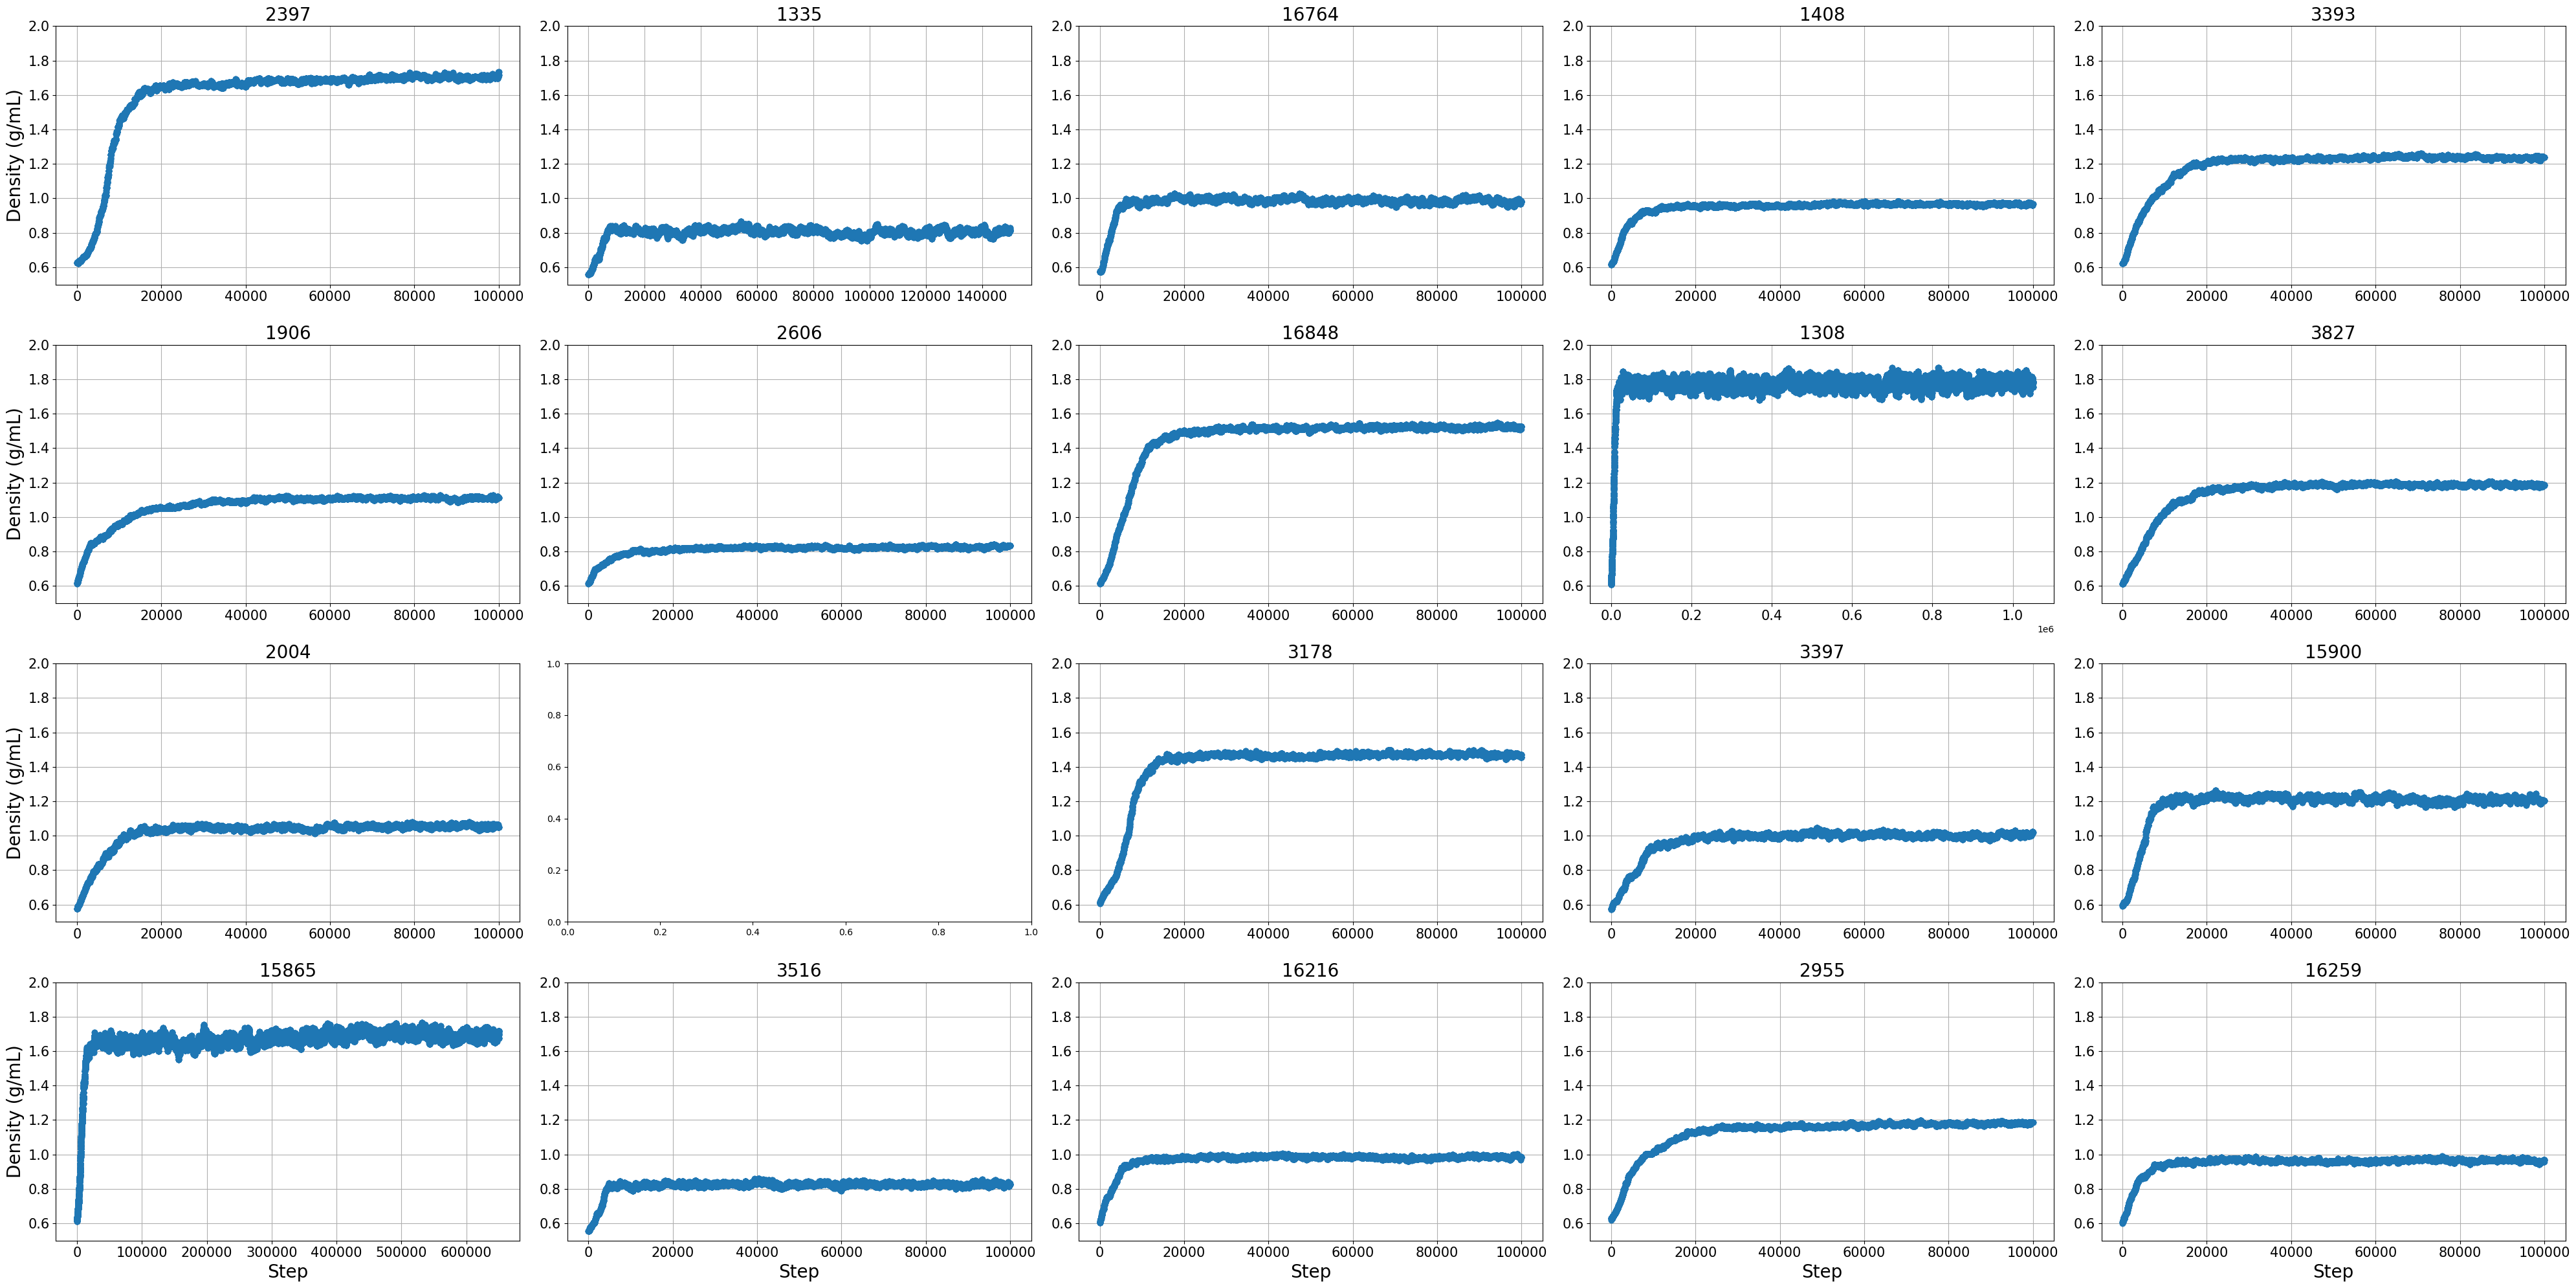

In [3]:
#plot all the densities in one plot (5x4)
import pandas as pd
import matplotlib.pyplot as plt
import glob
confids_to_test = [2397, 1906, 2004, 15865, 1335, 2606, 1498, 3516, 16764, 16848, 3178, 16216, 1408, 1308, 3397, 2955, 3393, 3827, 15900, 16259]

fig, axs = plt.subplots(4, 5, figsize=(40, 20))
for i, confid in enumerate(confids_to_test):
    try:
        filenames = glob.glob(f'trajectories/equil_test_10random_10diverse/equilibration_{confid}*.dat')
        #read in the dfs, and combine them vertically, if more then one
        dfs = [pd.read_csv(file) for file in filenames]
        df = pd.concat(dfs)
        df= df.sort_values(by='#"Step"', ascending=False)
        df = df.drop_duplicates(subset=['#"Step"'], keep='first')
        axs[i%4, i//4].plot(df['#"Step"'], df['Density (g/mL)'], marker='o', linestyle='-', label=confid)
        axs[i%4, i//4].set_title(f'{confid}', fontsize=20)
        axs[i%4, i//4].grid(True)
        #set the labels
        if i%4 == 3:
            axs[i%4, i//4].set_xlabel('Step',fontsize=20)
        if i//4 == 0:
            axs[i%4, i//4].set_ylabel('Density (g/mL)',fontsize=20)
        #also bigger ticklabels
        axs[i%4, i//4].tick_params(axis='both', which='major', labelsize=15)
        #and ylin 0.5-2.0
        axs[i%4, i//4].set_ylim(0.5, 2.0)

    except ValueError:
        print(f'No data for {confid}')
        continue
#set global title
plt.tight_layout()